### Q4

**Business Goal 4:** Identify the teams that have the most engagement on the main college basketball subreddit.  
**Technical Proposal:** Use grouping and sorting algorithms to find which college basketball teams are the most mentioned teams. Identify if these mentions ebb or flow over the course of the season. Incorporate external datasets such as basketball rankings to correlate mentions with popular games or teams.

### Setting up spark

In [1]:
spark

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 23, 6, Finished, Available)

### Loading Intermediate Data

In [2]:
workspace_default_storage_account = "aml6214727930"
workspace_default_container = "azureml-blobstore-6653633b-3460-4381-9199-d9e0f368353c"

workspace_wasbs_base_url = (
    f"wasbs://{workspace_default_container}@{workspace_default_storage_account}.blob.core.windows.net/"
)

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 23, 7, Finished, Available)

In [3]:
#datastore = 'azureml://datastores/workspaceblobstore/paths'
comments_path = "/basketball_comments_sep.parquet"
submissions_path = "/basketball_submissions_sep.parquet"

comments = spark.read.parquet(f"{workspace_wasbs_base_url}{comments_path}")
submissions = spark.read.parquet(f"{workspace_wasbs_base_url}{submissions_path}")

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 23, 8, Finished, Available)

### Data Cleaning

In [4]:
submissions = submissions.cache()
comments = comments.cache()

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 23, 9, Finished, Available)

In [5]:
submissions = submissions.filter((submissions.selftext != "") & (submissions.selftext != "[deleted]")& (submissions.selftext != "[removed]"))

comments = comments.filter(comments.body != "")

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 23, 10, Finished, Available)

In [10]:
from pyspark.sql.functions import col

submissions = submissions.select("subreddit", "author", "title", "selftext", "created_utc", "num_comments").filter(col("subreddit") == "CollegeBasketball")

comments = comments.select("subreddit", "author", "body", "parent_id", "created_utc").filter(col("subreddit") == "CollegeBasketball")

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 23, 15, Finished, Available)

In [11]:
# Check
submissions.show()

comments.show()

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 23, 16, Finished, Available)

+-----------------+------------------+--------------------+--------------------+-------------------+------------+
|        subreddit|            author|               title|            selftext|        created_utc|num_comments|
+-----------------+------------------+--------------------+--------------------+-------------------+------------+
|CollegeBasketball|           rCBBMod|Announcement: The...|Hello r/CollegeBa...|2022-03-17 14:00:50|           9|
|CollegeBasketball|     AutoModerator|[Weekly Post] Fre...|Are you new to th...|2022-04-29 15:00:11|           0|
|CollegeBasketball|     AutoModerator|[Weekly Post] Fre...|It's Free Talk Fr...|2022-04-29 15:00:11|           1|
|CollegeBasketball|            cbbBot|[Game Thread] Neb...|[Nebraska](#f/neb...|2022-02-23 00:54:05|          41|
|CollegeBasketball|            cbbBot|[Game Thread] Kan...|[Kansas State](#f...|2022-02-23 01:00:04|         626|
|CollegeBasketball|            cbbBot|[Game Thread] #24...|[Alabama](#f/alab...|2022-02-

In [13]:
submissions.count()

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 23, 18, Finished, Available)

9567

In [14]:
comments.count()

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 23, 19, Finished, Available)

1567798

### Distribution

In [15]:
# Define a dictionary of teams and associated keywords
team_keywords = {
    'houston': ['houston', 'cougars', 'uh'],
    'kansas': ['kansas', 'jayhawks', 'ku', 'rockchalk'],
    'villanova': ['villanova', 'wildcats', 'nova'],
    'duke': ['duke', 'blue devils'],
    'arkansas': ['arkansas', 'razorbacks', 'hogs', 'u of a'],
    'saint peters': ["saint peter's", 'peacocks', 'saint peters', "st. peter's", 'st peters', 'spu'],
    'north carolina': ['north carolina', 'tar heels', 'unc'],
    'miami': ['miami', 'hurricanes', 'um']
}

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 23, 20, Finished, Available)

In [17]:
from pyspark.sql.functions import lower

# Lowercase the text fields for uniformity
comments = comments.withColumn('body', lower(col('body')))
submissions = submissions.withColumn('title', lower(col('title')))\
                         .withColumn('selftext', lower(col('selftext')))

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 23, 22, Finished, Available)

In [18]:
from pyspark.sql.functions import udf, lit, array
from pyspark.sql.types import BooleanType

# Define the UDF to check the existence of key words
def keyword_present(text, keywords):
    if text:
        return any(keyword in text for keyword in keywords)
    return False

keyword_udf = udf(keyword_present, BooleanType())

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 23, 23, Finished, Available)

In [19]:
# Apply the UDF
for team, keywords in team_keywords.items():
    submissions = submissions.withColumn(
        team,
        keyword_udf(col("title"), array([lit(k) for k in keywords])) | keyword_udf(col("selftext"), array([lit(k) for k in keywords]))
    )
    comments = comments.withColumn(
        team, 
        keyword_udf(col("body"), array([lit(k) for k in keywords]))
    )

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 23, 24, Finished, Available)

In [20]:
# Check
submissions.printSchema

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 23, 25, Finished, Available)

<bound method DataFrame.printSchema of DataFrame[subreddit: string, author: string, title: string, selftext: string, created_utc: timestamp, num_comments: bigint, houston: boolean, kansas: boolean, villanova: boolean, duke: boolean, arkansas: boolean, saint peters: boolean, north carolina: boolean, miami: boolean]>

In [21]:
comments.printSchema

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 23, 26, Finished, Available)

<bound method DataFrame.printSchema of DataFrame[subreddit: string, author: string, body: string, parent_id: string, created_utc: timestamp, houston: boolean, kansas: boolean, villanova: boolean, duke: boolean, arkansas: boolean, saint peters: boolean, north carolina: boolean, miami: boolean]>

In [22]:
from pyspark.sql.functions import sum as sql_sum

# Aggregate the counts for submissions
submissions_counts = submissions.select([sql_sum(col(team).cast("int")).alias(team) for team in team_keywords.keys()])

# Aggregate the counts for comments
comments_counts = comments.select([sql_sum(col(team).cast("int")).alias(team) for team in team_keywords.keys()])

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 23, 27, Finished, Available)

In [23]:
print("Top 8 Team Mentions in Submissions")
submissions_counts.show()

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 23, 28, Finished, Available)

Top 8 Team Mentions in Submissions
+-------+------+---------+----+--------+------------+--------------+-----+
|houston|kansas|villanova|duke|arkansas|saint peters|north carolina|miami|
+-------+------+---------+----+--------+------------+--------------+-----+
|    454|   968|      385| 453|     371|         149|           809| 3102|
+-------+------+---------+----+--------+------------+--------------+-----+



In [24]:
print("Top 8 Team Mentions in Comments")
comments_counts.show()

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 23, 29, Finished, Available)

Top 8 Team Mentions in Comments
+-------+------+---------+-----+--------+------------+--------------+-----+
|houston|kansas|villanova| duke|arkansas|saint peters|north carolina|miami|
+-------+------+---------+-----+--------+------------+--------------+-----+
|  17144| 33921|    12317|31856|    9246|        6020|         46033|69595|
+-------+------+---------+-----+--------+------------+--------------+-----+



StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 23, 30, Finished, Available)

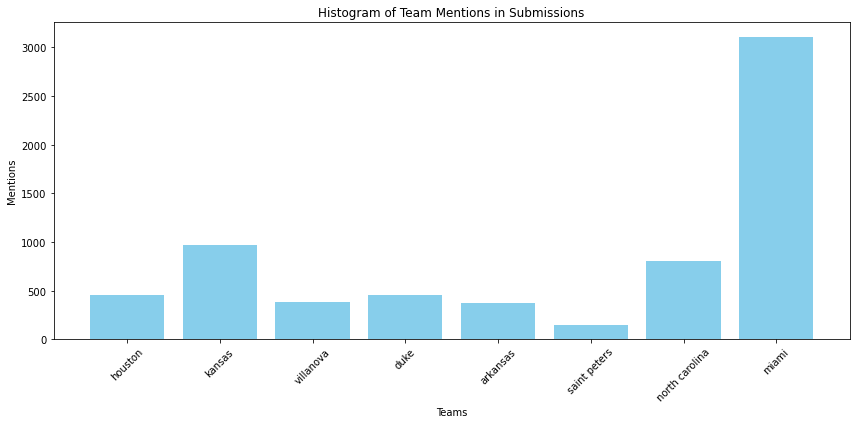

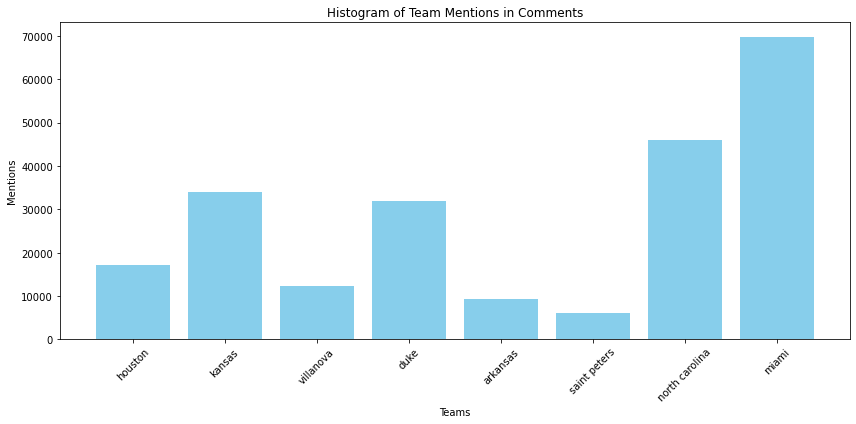

In [25]:
# Collect the data from PySpark DataFrame to Python
submissions_counts_data = submissions_counts.collect()[0].asDict()
comments_counts_data = comments_counts.collect()[0].asDict()

import matplotlib.pyplot as plt

# Function to plot histogram from a dictionary of team counts
def plot_histogram(team_counts, title):
    teams = list(team_counts.keys())
    counts = list(team_counts.values())

    plt.figure(figsize=(12, 6))
    plt.bar(teams, counts, color='skyblue')
    plt.title(title)
    plt.xlabel('Teams')
    plt.ylabel('Mentions')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot the histogram for submission counts
plot_histogram(submissions_counts_data, 'Histogram of Team Mentions in Submissions')

# Plot the histogram for comment counts
plot_histogram(comments_counts_data, 'Histogram of Team Mentions in Comments')

### Trend

In [26]:
from pyspark.sql.functions import dayofmonth, month, year

# Aggregate the daily mention counts for each team
daily_mentions_comments = comments.groupBy(
    year("created_utc").alias("year"),
    month("created_utc").alias("month"),
    dayofmonth("created_utc").alias("day")
).agg(
    sql_sum(col('kansas').cast('int')).alias('kansas'),
    sql_sum(col('duke').cast('int')).alias('duke'),
    sql_sum(col('north carolina').cast('int')).alias('north_carolina'),
    sql_sum(col('miami').cast('int')).alias('miami')
)

daily_mentions_submissions = submissions.groupBy(
    year("created_utc").alias("year"),
    month("created_utc").alias("month"),
    dayofmonth("created_utc").alias("day")
).agg(
    sql_sum(col('kansas').cast('int')).alias('kansas'),
    sql_sum(col('duke').cast('int')).alias('duke'),
    sql_sum(col('north carolina').cast('int')).alias('north_carolina'),
    sql_sum(col('miami').cast('int')).alias('miami')
)

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 23, 31, Finished, Available)

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 23, 32, Finished, Available)

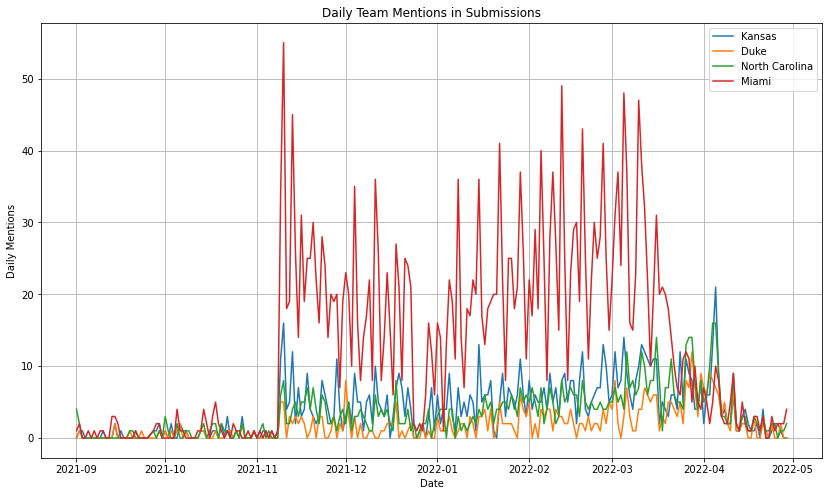

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Plot Daily Team Mentions in Submissions
# Convert the Spark DataFrame to a Pandas DataFrame
daily_mentions_submissions_pd = daily_mentions_submissions.toPandas()

# Convert year, month, day to a datetime object
daily_mentions_submissions_pd['date'] = pd.to_datetime(daily_mentions_submissions_pd[['year', 'month', 'day']])

# Set the 'date' column as index
daily_mentions_submissions_pd.set_index('date', inplace=True)

# Drop the year, month, and day columns
daily_mentions_submissions_pd.drop(['year', 'month', 'day'], axis=1, inplace=True)

# Sort the DataFrame by date
daily_mentions_submissions_pd.sort_index(inplace=True)

# Plot
plt.figure(figsize=(14, 8))

for column in daily_mentions_submissions_pd.columns:
    plt.plot(daily_mentions_submissions_pd.index, daily_mentions_submissions_pd[column], label=column.replace('_', ' ').title())

plt.xlabel('Date')
plt.ylabel('Daily Mentions')
plt.title('Daily Team Mentions in Submissions')
plt.legend()
plt.grid(True)
plt.show()

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 23, 33, Finished, Available)

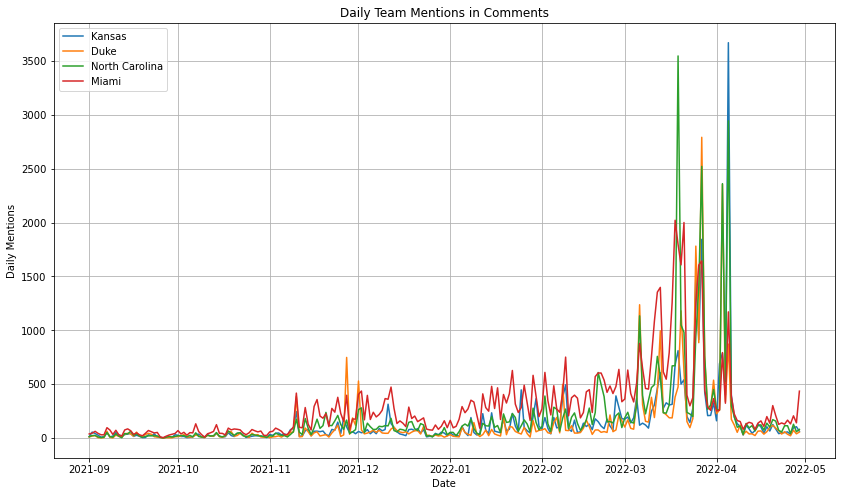

In [28]:
# Plot Daily Team Mentions in Comments
# Convert the Spark DataFrame to a Pandas DataFrame
daily_mentions_comments_pd = daily_mentions_comments.toPandas()

# Convert year, month, day to a datetime object
daily_mentions_comments_pd['date'] = pd.to_datetime(daily_mentions_comments_pd[['year', 'month', 'day']])

# Set the 'date' column as index
daily_mentions_comments_pd.set_index('date', inplace=True)

# Drop the year, month, and day columns
daily_mentions_comments_pd.drop(['year', 'month', 'day'], axis=1, inplace=True)

# Sort the DataFrame by date
daily_mentions_comments_pd.sort_index(inplace=True)

# Plot
plt.figure(figsize=(14, 8))

for column in daily_mentions_comments_pd.columns:
    plt.plot(daily_mentions_comments_pd.index, daily_mentions_comments_pd[column], label=column.replace('_', ' ').title())

plt.xlabel('Date')
plt.ylabel('Daily Mentions')
plt.title('Daily Team Mentions in Comments')
plt.legend()
plt.grid(True)
plt.show()